# Lightning Classification

This notebook shows a method of detection where in the picture a lightning could be located. Furthermore it is a method to detect areas of unusual brightness.

## Setting up the program

Obviously the program needs to have the commom data-wrangling packages: scipy, numpy, matplotlib etc.

The package imageio is needed to load the image files as numpy arrays, as scipy is deprecating the *misc.imread()* function within the next versions!

Additionally the package [lightnimage](https://github.com/the16thpythonist/lightnimage) is needed. It is a wrapper for the common operations used in the detection process such as calculating the difference of two images as well as, for example the row and column sums across an image.

It is recommended to just install the ligthnimage package, because all the required packages are listed among its dependencies and will thus be installed as well by pip.

To install the **lightnimage** package, just type into the command line:

```shell
pip3 install lightnimage
```

In [8]:
# built in imports
import os
import math

# Third party imports 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imageio
import numpy

import sklearn.externals.joblib as joblib

from lightnimage.image import LightningImage
from lightnimage.engine import SimpleAreaSegmentationEngine
from lightnimage.engine import SimpleAreaGroupingEngine
from lightnimage.engine import CustomSequenceAreaSegmentationEngine
from lightnimage.engine import SimpleLightningPreprocessingEngine
from lightnimage.util import draw_areas


To work properly the program needs *two* pictures: One being the one to process and detect lightning on, the other being a reference picture. Reference means, that it should possibly display the same scene, but *without a lightning*. This is most of the time a reasonable requirement, as when looking at a video, the frame just before the lightning burst could be used for example.

In [9]:
# Defining the pictures for the analysis
BASE_PATH = '/home/jonas/Nextcloud/Programmieren/PyCharm/aragats'
FOLDER_PATH = os.path.join(BASE_PATH, 'data')
SOURCE_PATH = os.path.join(BASE_PATH, 'src')
# These are the Images used for demonstration
#REFERENCE_IMAGE_NAME = 'aragats-0181.jpg'
#DETECTION_IMAGE_NAME = 'aragats-0186.jpg'
REFERENCE_IMAGE_NAME = 'aragats-0181.jpg'
DETECTION_IMAGE_NAME = 'aragats-0182.jpg'


Text(0.5, 1.0, 'Image with lightning')

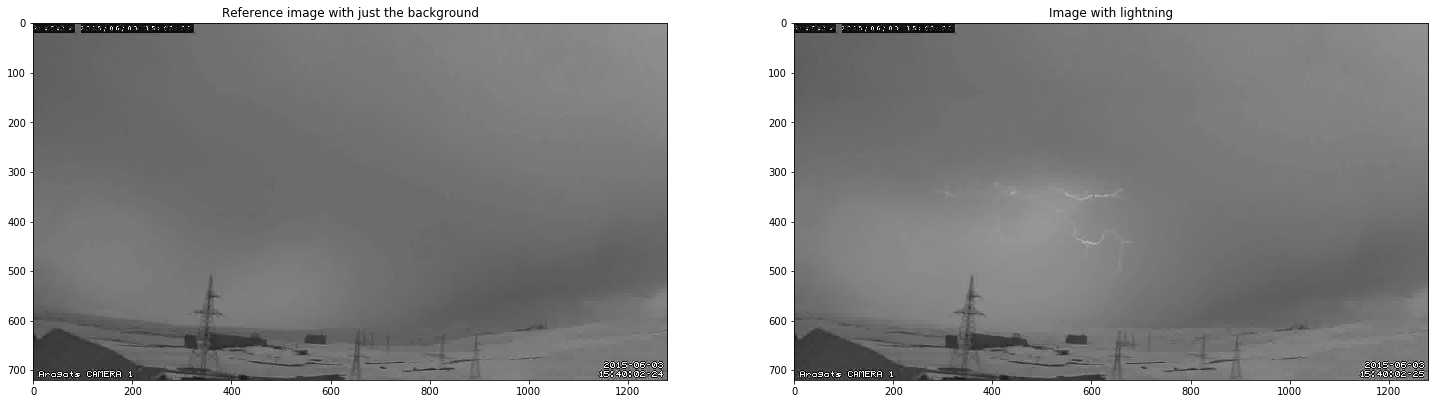

In [10]:
# Creating the actual paths from these file names
reference_image_path = os.path.join(FOLDER_PATH, REFERENCE_IMAGE_NAME)
detection_image_path = os.path.join(FOLDER_PATH, DETECTION_IMAGE_NAME)

# Loading the pictures into memory as gray scale value matrices
reference_image_array = imageio.imread(reference_image_path, pilmode='L')
detection_image_array = imageio.imread(detection_image_path, pilmode='L')

# Creating the LightningImage objects based on these matrices
reference_lightning_image = LightningImage(reference_image_array)
detection_lightning_image = LightningImage(detection_image_array)

# Showing the pictures to be used 
figure1 = plt.figure(figsize=(25, 25))
ax1 = figure1.add_subplot(1, 2, 1)
ax1.imshow(reference_image_array, cmap='gray')
ax1.set_title('Reference image with just the background')

ax2 = figure1.add_subplot(1, 2, 2)
ax2.imshow(detection_image_array, cmap='gray')
ax2.set_title('Image with lightning')


## Preprocessing

For pre porcessing, first the background is removed by subtracting the reference picture from the actual image. This difference picture is then converted into a 

In [ ]:
# IMAGE CLASSIFICATION

# Loading the trained machine learning model for lightning classification
classification_model = joblib.load(FOLDER_PATH)

In [ ]:

detection_mean = numpy.mean(detection_lightning_image.array)
reference_mean = numpy.mean(reference_lightning_image.array)
mean_difference = detection_mean - reference_mean
print('DIFFERENCE IN GRAY SCALE AVERAGES OF BACKGROUND AND DETECTION:\n{}'.format(mean_difference))

if mean_difference < 1.1:
    print('NO LIGHTNING DETECTED!')
else:
    print('LIGHTNING DETECTED!')

# Calculating the difference of the two to get rid of the timestamps and most of the background
difference_lightning_image = detection_lightning_image - reference_lightning_image  # type: LightingImage

# The timestamps on the images are a white color, that has nothing to do with the actual lightning/scenery
# Thus they need to be removed from the image, as to not influence the calculation of the max/mean gray scale value, 
# as it is done in the pre processing engine later on
def remove_timestamp_mask(v, i, j):
    height = difference_lightning_image.height
    if height * 0.93 <= i or height * 0.05 >= i:
        return 0
    else:
        return v
    

difference_lightning_image.transform_element_wise(remove_timestamp_mask)

# A value a bit over the mean of the image will be used as static threshold
static_threshold = numpy.mean(difference_lightning_image.array)
# Using the pre processing engine to create a binary mask dynamically based on the difference image
# TODO: Make the preprocessing also use a coefficient, that tells the spacial coverage of optical mass 
pre_processing_config = {
    'static_threshold': static_threshold,
    'threshold_function': lambda m, a: m - m * (0.43 + 0.0005 * (255 - m))
}
pre_processing_engine = SimpleLightningPreprocessingEngine(pre_processing_config)

binary_lightning_image = pre_processing_engine(difference_lightning_image)
# TODO: Add the possibility that there just is no lightning: LightningDetectionEngine?

f, (ax2, ax3) = plt.subplots(1, 2)
ax2.imshow(difference_lightning_image.array, cmap='gray')
ax3.imshow(binary_lightning_image.array, cmap='gray')


## How it works

The detection engine computes the sums of the gray scale values along each column and along each row. These sums form two data sets aling these axes. These data sets have very distinct peaks, which are detected by using a threshold value (relative to the average of the whole set). Like this there will be one, possibly multiple sequences along the axes of the image, where those sums have exceeded the threshold. It will result in a list of start and end indices for these sequences for both the x and y axis:

```python
x_sequences = [(23, 187), (199, 786)]
y_sequences = [(100, 320), (600, 700)]
```

These one dimensional stretches along the axis are then used to create every possible combination of x and y sequences resulting in a number of 2 dimensional areas (which are defined by the start and end index along x and y) where a anomaly *could* be:

```python
areas = [
    ((23, 187), (100, 320)),
    ((199, 786), (100, 320)),
    ((23, 187), (600, 700)),
    ((199, 786), (600, 700))
]
```

### False positives

This technique obviously creates a lot of wrong areas. To remove those false positives each area is checked, by calculating the average gray scale value of every pixel *within an area* and if it does not match a certain threshold, that can be expected, when looking for unussually bright areas, that area is discarded from the final result.
The left over is 

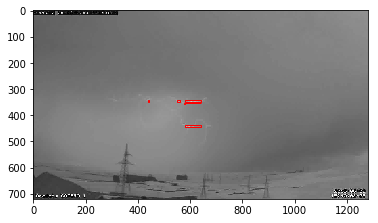

In [5]:

# TODO: Sequencing function based on the floating average of the derivative of the sume function?
def sequence_function(array):
    m = numpy.amax(array)
    factor = 0.02
    return CustomSequenceAreaSegmentationEngine.sequence_function_generator(
        lambda i, v, a: v >= m * factor,
        lambda i, v, a: v < m * factor
    )(array)
    

# We first run the detection algorithm without validity checks to illustrate the working principle 
detection_config = {
    'sequence_function':    sequence_function, 
    'checking':             True
}
segmentation_engine = CustomSequenceAreaSegmentationEngine(detection_config)
areas = segmentation_engine(binary_lightning_image)

f, ax4 = plt.subplots(1, 1)
ax4.imshow(detection_image_array, cmap='gray')

# Overlaying the detected areas with the original picture
draw_areas(ax4, areas)


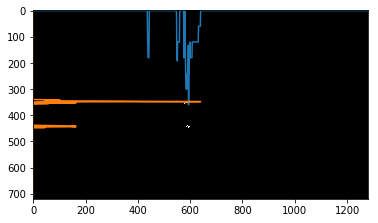

In [6]:
# Here we illustrate how the detection algorithm works basically
# It just detects anomalies in the vertical and horizontal sum functions of the picture
y_sum = binary_lightning_image.column_sum(scale=binary_lightning_image.width/2)
x_sum = binary_lightning_image.row_sum(scale=binary_lightning_image.height/2)

# We plot the sums into the same picture
x = numpy.arange(0, binary_lightning_image.width)
y = numpy.arange(0, binary_lightning_image.height)

f, ax5 = plt.subplots(1, 1)
ax5.imshow(binary_lightning_image.array, cmap='gray')
ax5.plot(x, x_sum)
ax5.plot(y_sum, y)


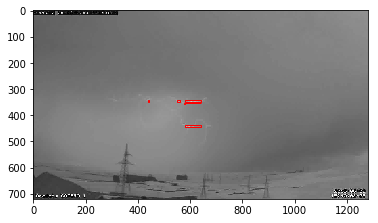

In [7]:
# Now we are doing the same thing, but with the checking enabled.
# The checking will get rid of all the areas, which do not contain "enough optical mass" to be recognized as lightnings.
# Removing all the false positives, that were created through the one dimensional area algorithm
segmentation_engine.config['checking'] = True
segmentation_engine.config['check_threshold'] = 0.035
areas = segmentation_engine(binary_lightning_image)

f, ax6 = plt.subplots(1, 1)
ax6.imshow(detection_image_array, cmap='gray')

draw_areas(ax6, areas)


## Grouping Engine

The grouping takes the areas and then based on a specific weight function groups certain areas together.

This works by calculating the grouping weight for each possible pairing between the given areas. The weight can be derived as any function of the two parameters: The distance between the areas and their combined size. Is the weight smaller than a given threshold, the areas *will be grouped*. Is the weight higher, they wont. This pairwise computation then leads to bigger groups (that are interconnected with at least one node).

Here in this example we use the weight function $w(d, s) = d + \sqrt{s}$, where d is the distance and s the size. And since the weight has to be smaller than the threshold to create a grouping, this means we assume, that the smaller the distance and the size of the areas the more likely it is that they belong together.

All the areas of these groups will be combined to one big area. All these combined areas will form the final areas computed by the lightning detection pipleline.

THE AREAS BEFORE:
[((437, 444), (341, 351)), ((548, 560), (341, 351)), ((576, 580), (355, 358)), ((581, 640), (341, 351)), ((581, 640), (352, 354)), ((581, 640), (439, 445))]
THE FINAL, REMAINING AREAS
[((437, 640), (341, 445))]


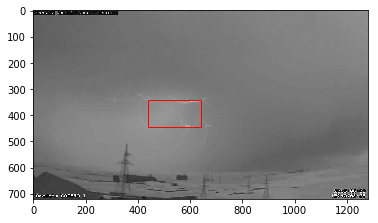

In [8]:
# Now we group the areas together
grouping_config = {
    'weight_function': lambda d, s: 0.0047*d**2 + s**(0.4),
    'threshold':    200
}
grouping_engine = SimpleAreaGroupingEngine(grouping_config)
grouped_areas = grouping_engine(areas)
#EXPERIMENTAL
grouped_areas = grouping_engine(grouped_areas)
print('THE AREAS BEFORE:\n{}'.format(areas))
print('THE FINAL, REMAINING AREAS\n{}'.format(grouped_areas))

f, ax7 = plt.subplots(1, 1)
ax7.imshow(detection_image_array, cmap='gray')

draw_areas(ax7, grouped_areas)


## Open issues 

### Relative Thresholding

Using a threshold realtive to the average, when detecting peaks in the column- and row-sums has shown to have some issues: When there are two lightnings in the picture, with one being a lot dimmer than the other, only the bright one is being detected, because the bright one is contributing most to the average of the sums.

A possible solution would be to just completely remove the detected areas from the original picture and run the whole program on it multiple times until nothing is being detected anymore.

Additionally the relative thresholding should be replaced with just using a callback function in the config, so a custom calculation can be used to compare the threshold against.

### On the edge of the threshold

Another problem occurs, when the lightning has just the right brightness, so that the threshold value, which detects the peaks of the sum functions was calculated in such a ways, that it detects *too many, small* peaks. The result is not one area around the entirety of the lightning, but many small areas around various parts of the lightning and sometimes the terrain as well (!)

A possible solution would be to use a grouping engine after the detection engine, which would group together some areas, based on A) how far they are apart (lower the probability) and B) How big they are (smaller areas are more likely to be false positive)